In [1]:
import warnings
warnings.filterwarnings("ignore")
# Libraries to read and manipulate data
import pandas as pd
import numpy as np

# libraries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Libraries to tune model, get different metric scores, and split data
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline, make_pipeline
from statsmodels.api import OLS, add_constant

#libraries to help with model building
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
    BaggingClassifier)
from xgboost import XGBClassifier

#libraries for convenience
from datetime import datetime
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
# use the same data from the OLS and Linear regression code.
data = pd.read_csv('../Resources/Reg_season_consolidated.csv')
playoffs = pd.read_csv('../Resources/Playoff_games.csv')
# copying data to preserve original
games_data = data.copy()
playoffs.drop(['Unnamed: 0'],axis= 1)
playoffs = playoffs[['HOME_TEAM_NAME','GAME_DATE']]
playoffs

,HOME_TEAM_NAME,GAME_DATE
0,Pistons,2004-06-15
1,Pistons,2004-06-13
2,Pistons,2004-06-10
3,Lakers,2004-06-08
4,Lakers,2004-06-06
...,...,...
1491,Jazz,2021-05-23
1492,Bucks,2021-05-22
1493,Clippers,2021-05-22
1494,Nets,2021-05-22


In [3]:
# getting the playoff data into years and subtracting 1 to get the current season.
# because the 2004 playoffs will be in 2005 for example.
playoffs['GAME_DATE'] = pd.to_datetime(playoffs['GAME_DATE'],yearfirst=True)
playoffs['GAME_DATE'] = pd.DatetimeIndex(playoffs['GAME_DATE']).year
playoffs['GAME_DATE'] = playoffs['GAME_DATE'] - 1
playoffs

,HOME_TEAM_NAME,GAME_DATE
0,Pistons,2003
1,Pistons,2003
2,Pistons,2003
3,Lakers,2003
4,Lakers,2003
...,...,...
1491,Jazz,2020
1492,Bucks,2020
1493,Clippers,2020
1494,Nets,2020


In [4]:
# creating a comparison tool.
playoffs['UNIQUE_SEASONS'] = playoffs['HOME_TEAM_NAME'] + '-' + playoffs.GAME_DATE.astype(str)
playoffs

,HOME_TEAM_NAME,GAME_DATE,UNIQUE_SEASONS
0,Pistons,2003,Pistons-2003
1,Pistons,2003,Pistons-2003
2,Pistons,2003,Pistons-2003
3,Lakers,2003,Lakers-2003
4,Lakers,2003,Lakers-2003
...,...,...,...
1491,Jazz,2020,Jazz-2020
1492,Bucks,2020,Bucks-2020
1493,Clippers,2020,Clippers-2020
1494,Nets,2020,Nets-2020


In [5]:
playoffs = playoffs.groupby(['UNIQUE_SEASONS']).sum()
playoffs

,GAME_DATE
UNIQUE_SEASONS,
76ers-2004,4008
76ers-2007,6021
76ers-2008,6024
76ers-2010,4020
76ers-2011,12066
...,...
Wizards-2013,10065
Wizards-2014,10070
Wizards-2016,12096


In [6]:
# this is a rather odd way of getting every unique instance of each team appearing in the playoffs based on year.
playoffs['UNIQUE_SEASONS'] = playoffs.index
playoffs.reset_index(inplace=True,drop=True)
playoffs = playoffs.drop(['GAME_DATE'],axis=1)
playoffs

,UNIQUE_SEASONS
0,76ers-2004
1,76ers-2007
2,76ers-2008
3,76ers-2010
4,76ers-2011
...,...
283,Wizards-2013
284,Wizards-2014
285,Wizards-2016
286,Wizards-2017


In [7]:
playoff_list = list(playoffs['UNIQUE_SEASONS'])
# this list will be used to check if a team had made the playoffs or not.

In [8]:
games_data = games_data.drop(['Unnamed: 0'],axis=1)
# using the UNIQUE seasons column again to compare the teams
games_data['UNIQUE_SEASONS'] = games_data['TEAM_NAME'] + '-' + games_data.Year.astype(str)
# dummy defaults to zero.
games_data['Made_Playoffs'] = 0
games_data

,TEAM_NAME,2pointer_PCT_AVG,3pointer_PCT_AVG,FreeThrow_PCT_AVG,Assists_AVG,Rebounds_AVG,WINS,Year,Attendance,UNIQUE_SEASONS,Made_Playoffs
0,76ers,43.768,35.133,78.765,20.854,42.012,43,2004,788.128,76ers-2004,0
1,76ers,45.973,36.028,75.584,20.159,40.220,38,2005,732.686,76ers-2005,0
2,76ers,45.863,34.962,76.713,20.354,39.659,35,2006,677.278,76ers-2006,0
3,76ers,46.049,32.263,70.148,20.402,41.915,40,2007,608.603,76ers-2007,0
4,76ers,46.083,31.345,74.339,20.085,41.159,41,2008,609.675,76ers-2008,0
...,...,...,...,...,...,...,...,...,...,...,...
505,Wizards,47.611,37.404,78.724,23.854,42.854,49,2016,725.426,Wizards-2016,0
506,Wizards,46.793,37.319,77.612,25.229,43.040,43,2017,697.107,Wizards-2017,0
507,Wizards,46.822,33.920,76.522,26.268,42.354,32,2018,718.946,Wizards-2018,0
508,Wizards,46.209,37.228,78.238,25.328,41.688,24,2019,716.996,Wizards-2019,0


In [9]:
#looping through each season to check against the unique year/team combos in the playoffs.
for idx in np.arange(0,len(games_data['UNIQUE_SEASONS']),1):
    if games_data['UNIQUE_SEASONS'][idx] in playoff_list:
        # fill in the dummy with a 1, indicating playoffs were made.
        games_data['Made_Playoffs'][idx] = 1
games_data

,TEAM_NAME,2pointer_PCT_AVG,3pointer_PCT_AVG,FreeThrow_PCT_AVG,Assists_AVG,Rebounds_AVG,WINS,Year,Attendance,UNIQUE_SEASONS,Made_Playoffs
0,76ers,43.768,35.133,78.765,20.854,42.012,43,2004,788.128,76ers-2004,1
1,76ers,45.973,36.028,75.584,20.159,40.220,38,2005,732.686,76ers-2005,0
2,76ers,45.863,34.962,76.713,20.354,39.659,35,2006,677.278,76ers-2006,0
3,76ers,46.049,32.263,70.148,20.402,41.915,40,2007,608.603,76ers-2007,1
4,76ers,46.083,31.345,74.339,20.085,41.159,41,2008,609.675,76ers-2008,1
...,...,...,...,...,...,...,...,...,...,...,...
505,Wizards,47.611,37.404,78.724,23.854,42.854,49,2016,725.426,Wizards-2016,1
506,Wizards,46.793,37.319,77.612,25.229,43.040,43,2017,697.107,Wizards-2017,1
507,Wizards,46.822,33.920,76.522,26.268,42.354,32,2018,718.946,Wizards-2018,0
508,Wizards,46.209,37.228,78.238,25.328,41.688,24,2019,716.996,Wizards-2019,0


In [10]:
# create the X and y frames of the model.
X = games_data.drop(['Year','TEAM_NAME','UNIQUE_SEASONS','Made_Playoffs'],axis=1)
y = games_data['Made_Playoffs']

In [11]:
# split the data like a banana.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=15, stratify=y)
print(X_train.shape, X_test.shape)

(382, 7) (128, 7)


In [12]:
# Use Scaler because of the attendance data being all over the place.
scaler = StandardScaler()
X_scaler = scaler.fit(X_train)

In [13]:
# Scaling data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [14]:
# basic untued models used in classes to keep track of names, and the model itself for future exportations
# this is used to dynamicallhy export the models based on best performing.
class decisiontree:
    name = "Decision Tree Classifier"
    model = DecisionTreeClassifier(random_state=1)
class bagging:
    name = "Bagging Classifier"
    model = BaggingClassifier(random_state=1)
class logitreg:
    name = "Logistic Regression Classifier"
    model = LogisticRegression(solver='lbfgs', random_state=1)
class randiforestclass:
    name = "Random Forest Classifier"
    model = RandomForestClassifier(random_state=1)
class adaboost:
    name = "AdaBoost Classifier"
    model = AdaBoostClassifier(random_state=1)
class gradientboost:
    name = "Gradient Boosting Classifier"
    model = GradientBoostingClassifier(init=AdaBoostClassifier(random_state=1),random_state=1)
class xgboost:
    name = "Extreme Gradient Boosting Classifier"
    model = XGBClassifier(random_state=1,eval_metric='logloss')
class_list = [decisiontree, bagging, logitreg, randiforestclass, adaboost, gradientboost, xgboost]

In [15]:
# Functions on Functions on Functions
def buildmodel(model_class,xtrn,ytrn,xtst):
    # Using the model classes and specifically the model variable this will fit the training and make the prediction using 
    # the x testing set
    model_class.model.fit(xtrn,ytrn)
    model_class.y_predict = model_class.model.predict(xtst)
    print("Model build and fitted :)")
    
def metricsomania(model_class,train,test,train_y,test_y,flag=True):
    # Use the model class, the model variable of said class, and the y predictions
    # defining an empty list to store train and test results
    # Will also create a list of the scores and put the list into the class.
    model = model_class.model
    score_list=[] 
    # Including the Testing set to see how overfitting may be influencing the model.
    pred_train = model.predict(train)
    pred_test = model_class.y_predict
    
    train_acc = model.score(train,train_y)
    test_acc = model.score(test,test_y)
    
    train_recall = metrics.recall_score(train_y,pred_train)
    test_recall = metrics.recall_score(test_y,pred_test)
    
    train_precision = metrics.precision_score(train_y,pred_train)
    test_precision = metrics.precision_score(test_y,pred_test)
    
    score_list.extend((train_acc,test_acc,train_recall,test_recall,train_precision,test_precision))
    if len(score_list) == 0:
        flag = False
    # If the flag is set to True then only the following print statements will be dispayed. The default value is set to True.
    # If the flag is not True, god help us
    if flag == True: 
        print("Accuracy on training set : ",model.score(train,train_y))
        print("Accuracy on test set : ",model.score(test,test_y))
        print("Recall on training set : ",metrics.recall_score(train_y,pred_train))
        print("Recall on test set : ",metrics.recall_score(test_y,pred_test))
        print("Precision on training set : ",metrics.precision_score(train_y,pred_train))
        print("Precision on test set : ",metrics.precision_score(test_y,pred_test))
    
    model_class.scores = score_list
    return score_list # returning the list with train and test scores

def make_confusion_matrix(model_class,y_actual,labels=[1, 0]):
    # Make a confusion matrix with a seaborn heatmap and display it.
    model = model_class.model
    cm=metrics.confusion_matrix( y_actual, model_class.y_predict, labels=[0, 1])
    df_cm = pd.DataFrame(cm, index = [i for i in ["Actual - No","Actual - Yes"]],
                  columns = [i for i in ['Predicted - No','Predicted - Yes']])
    
    group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cm.flatten()/np.sum(cm)]
    
    labels = [f"{v1}\n{v2}" for v1, v2 in
              zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    
    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=labels,fmt='')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def Everything_Everywhere_All_At_Once(model_class,xtrn,ytrn,xtst,ytst):
    # Run all of the other functions to reduce the code needed to do it all
    print(f"Model creation, fitting, and assesment of the {model_class.name} model:")
    buildmodel(model_class,xtrn,ytrn,xtst)
    print("-"*50)
    metricsomania(model_class,xtrn,xtst,ytrn,ytst)
    make_confusion_matrix(model_class,ytst)
    print("-"*50)

COPYPASTA time. using this function we can make so many models.


Model creation, fitting, and assesment of the Decision Tree Classifier model:
Model build and fitted :)
--------------------------------------------------
Accuracy on training set :  1.0
Accuracy on test set :  0.8125
Recall on training set :  1.0
Recall on test set :  0.8235294117647058
Precision on training set :  1.0
Precision on test set :  0.8235294117647058
--------------------------------------------------


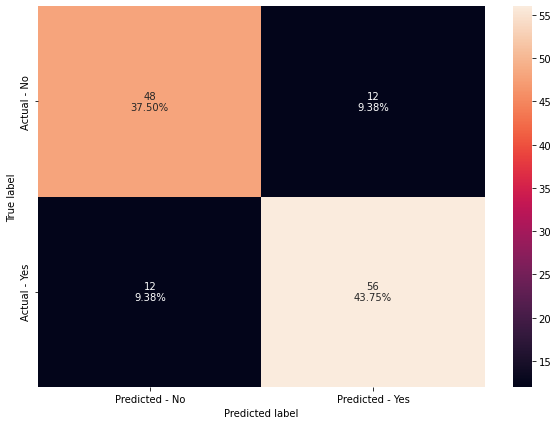

In [16]:
Everything_Everywhere_All_At_Once(decisiontree,X_train_scaled,y_train,X_test_scaled,y_test)

Model creation, fitting, and assesment of the Bagging Classifier model:
Model build and fitted :)
--------------------------------------------------
Accuracy on training set :  0.9973821989528796
Accuracy on test set :  0.875
Recall on training set :  0.9950980392156863
Recall on test set :  0.8823529411764706
Precision on training set :  1.0
Precision on test set :  0.8823529411764706
--------------------------------------------------


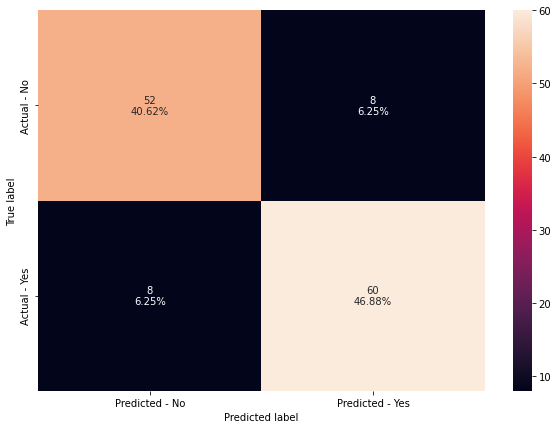

In [17]:
Everything_Everywhere_All_At_Once(bagging,X_train_scaled,y_train,X_test_scaled,y_test)

Model creation, fitting, and assesment of the Logistic Regression Classifier model:
Model build and fitted :)
--------------------------------------------------
Accuracy on training set :  0.918848167539267
Accuracy on test set :  0.890625
Recall on training set :  0.9411764705882353
Recall on test set :  0.9264705882352942
Precision on training set :  0.909952606635071
Precision on test set :  0.875
--------------------------------------------------


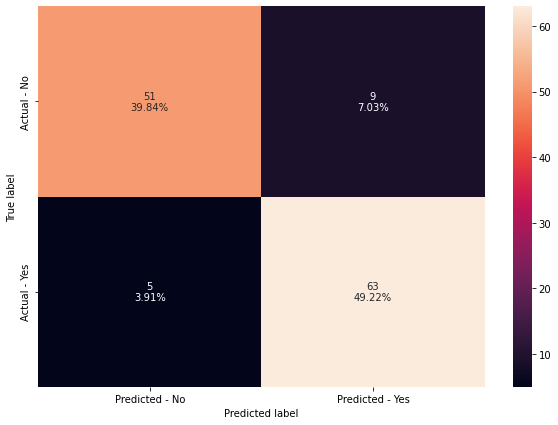

In [18]:
Everything_Everywhere_All_At_Once(logitreg,X_train_scaled,y_train,X_test_scaled,y_test)

Model creation, fitting, and assesment of the Random Forest Classifier model:
Model build and fitted :)
--------------------------------------------------
Accuracy on training set :  1.0
Accuracy on test set :  0.8828125
Recall on training set :  1.0
Recall on test set :  0.8970588235294118
Precision on training set :  1.0
Precision on test set :  0.8840579710144928
--------------------------------------------------


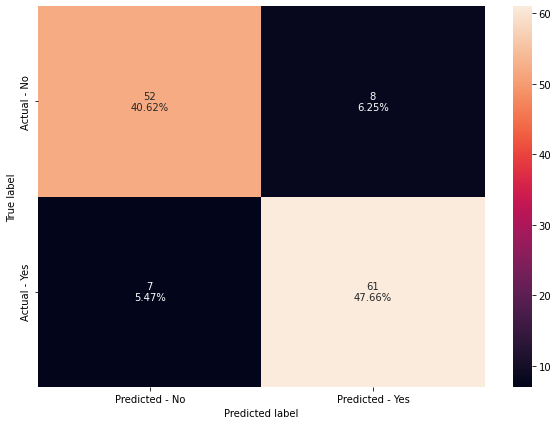

In [19]:
Everything_Everywhere_All_At_Once(randiforestclass,X_train_scaled,y_train,X_test_scaled,y_test)

Model creation, fitting, and assesment of the AdaBoost Classifier model:
Model build and fitted :)
--------------------------------------------------
Accuracy on training set :  0.9764397905759162
Accuracy on test set :  0.8125
Recall on training set :  0.9705882352941176
Recall on test set :  0.8970588235294118
Precision on training set :  0.9850746268656716
Precision on test set :  0.782051282051282
--------------------------------------------------


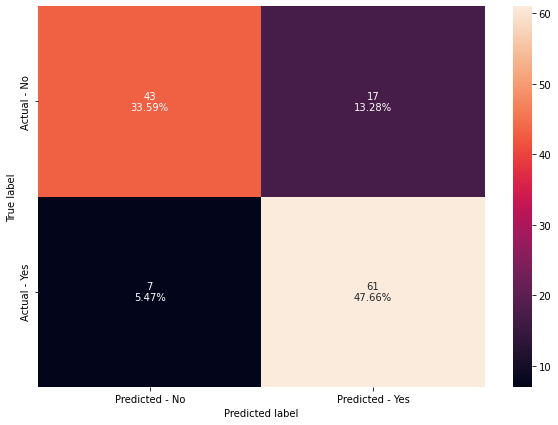

In [20]:
Everything_Everywhere_All_At_Once(adaboost,X_train_scaled,y_train,X_test_scaled,y_test)

Model creation, fitting, and assesment of the Gradient Boosting Classifier model:
Model build and fitted :)
--------------------------------------------------
Accuracy on training set :  1.0
Accuracy on test set :  0.875
Recall on training set :  1.0
Recall on test set :  0.8970588235294118
Precision on training set :  1.0
Precision on test set :  0.8714285714285714
--------------------------------------------------


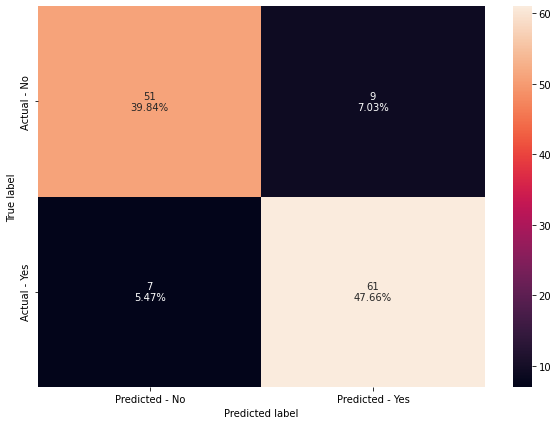

In [21]:
Everything_Everywhere_All_At_Once(gradientboost,X_train_scaled,y_train,X_test_scaled,y_test)

Model creation, fitting, and assesment of the Extreme Gradient Boosting Classifier model:
Model build and fitted :)
--------------------------------------------------
Accuracy on training set :  1.0
Accuracy on test set :  0.875
Recall on training set :  1.0
Recall on test set :  0.9117647058823529
Precision on training set :  1.0
Precision on test set :  0.8611111111111112
--------------------------------------------------


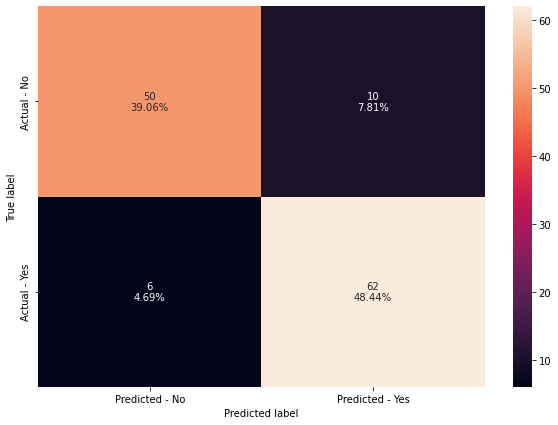

In [22]:
Everything_Everywhere_All_At_Once(xgboost,X_train_scaled,y_train,X_test_scaled,y_test)

In [23]:
# make a dataframe of the different models by using these lists filled with the help of the classes.
model_names = []
acc_train = []
acc_test = []
recall_train = []
recall_test = []
precision_train = []
precision_test = []
for model_class in class_list:
    model_names.append(model_class.name)
    acc_train.append(model_class.scores[0])
    acc_test.append(model_class.scores[1])
    recall_train.append(model_class.scores[2])
    recall_test.append(model_class.scores[3])
    precision_train.append(model_class.scores[4])
    precision_test.append(model_class.scores[5])

In [24]:
# actually build the frame with these sets.
# training metrics are kept to see problems of overfitting.
comparison_frame = pd.DataFrame(
    {
        "Model": model_names,
        "Train_Accuracy": acc_train,
        "Test_Accuracy": acc_test,
        "Train_Recall": recall_train,
        "Test_Recall": recall_test,
        "Train_Precision": precision_train,
        "Test_Precision": precision_test,
    }
)
#comparison_frame.sort_values(by='Test_Accuracy')
comparison_frame

,Model,Train_Accuracy,Test_Accuracy,Train_Recall,Test_Recall,Train_Precision,Test_Precision
0,Decision Tree Classifier,1.000,0.812,1.000,0.824,1.000,0.824
1,Bagging Classifier,0.997,0.875,0.995,0.882,1.000,0.882
2,Logistic Regression Classifier,0.919,0.891,0.941,0.926,0.910,0.875
3,Random Forest Classifier,1.000,0.883,1.000,0.897,1.000,0.884
4,AdaBoost Classifier,0.976,0.812,0.971,0.897,0.985,0.782
5,Gradient Boosting Classifier,1.000,0.875,1.000,0.897,1.000,0.871
6,Extreme Gradient Boosting Classifier,1.000,0.875,1.000,0.912,1.000,0.861


In [25]:
# sorting the frame to get top models.
comparison_frame.sort_values(by=['Test_Accuracy'], inplace=True, ascending=False)
comparison_frame.reset_index(inplace=True,drop=True)
# comparison_frame.drop('index')
comparison_frame

,Model,Train_Accuracy,Test_Accuracy,Train_Recall,Test_Recall,Train_Precision,Test_Precision
0,Logistic Regression Classifier,0.919,0.891,0.941,0.926,0.910,0.875
1,Random Forest Classifier,1.000,0.883,1.000,0.897,1.000,0.884
2,Bagging Classifier,0.997,0.875,0.995,0.882,1.000,0.882
3,Gradient Boosting Classifier,1.000,0.875,1.000,0.897,1.000,0.871
4,Extreme Gradient Boosting Classifier,1.000,0.875,1.000,0.912,1.000,0.861
5,Decision Tree Classifier,1.000,0.812,1.000,0.824,1.000,0.824
6,AdaBoost Classifier,0.976,0.812,0.971,0.897,0.985,0.782


### Hyperparameter Tuning
#### To my teammates:
Gridsearch is a tool used to bruteforce search a matrix of hyperparameters for a model. The model will be optimized to the training set so overfitting is a risk. However, in my experience a tuned model is very powerful so we'll see how effective this is.
#### To anyone else whom it may concern:
Using gridsearch to tune the hyperparameters was used to be used to create a stonger model
They are commented out so running the code again wont take a long time.

In [26]:
# # Creating pipeline
# pipe = make_pipeline(StandardScaler(), DecisionTreeClassifier(random_state=1))

# # Parameter grid to pass in GridSearchCV

# param_grid = {'decisiontreeclassifier__max_depth': np.arange(2,30), 
#               'decisiontreeclassifier__min_samples_leaf': [1, 2, 5, 7, 10],
#               'decisiontreeclassifier__max_leaf_nodes' : [2, 3, 5, 10,15],
#               'decisiontreeclassifier__min_impurity_decrease': [0.0001,0.001,0.01,0.1]
#              }

# # Type of scoring used to compare parameter combinations
# scorer = metrics.make_scorer(metrics.accuracy_score)

# # Calling GridSearchCV
# grid_cv = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=scorer, cv=5, n_jobs = -1)

# # Fitting parameters in GridSeachCV
# grid_cv.fit(X_train_scaled, y_train)

# print(
#     "Best Parameters:{} \nScore: {}".format(grid_cv.best_params_, grid_cv.best_score_)
# )

Model creation, fitting, and assesment of the Tuned Decision Tree Classifier model:
Model build and fitted :)
--------------------------------------------------
Accuracy on training set :  0.9267015706806283
Accuracy on test set :  0.8671875
Recall on training set :  0.9215686274509803
Recall on test set :  0.8676470588235294
Precision on training set :  0.94
Precision on test set :  0.8805970149253731
--------------------------------------------------


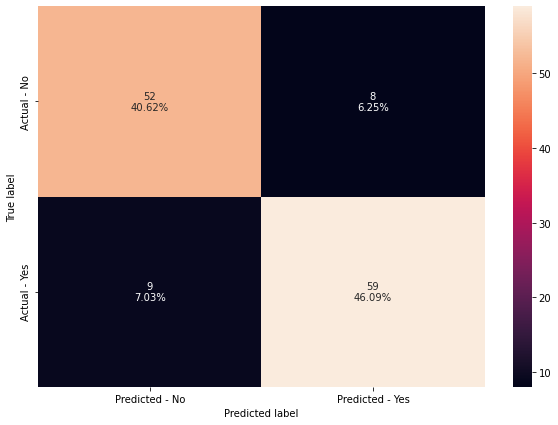

In [27]:
# build a class for the tuned model.
class tuned_decision_tree:
    name = "Tuned Decision Tree Classifier"
tuned_decision_tree.model = make_pipeline(
    StandardScaler(),
    DecisionTreeClassifier(
        max_depth=4,
        max_leaf_nodes=5,
        random_state=1,
        min_impurity_decrease=0.0001,
        min_samples_leaf=10
    ),
)
# adding the class to the list of classes
class_list.append(tuned_decision_tree)
Everything_Everywhere_All_At_Once(tuned_decision_tree,X_train_scaled,y_train,X_test_scaled,y_test)

In [28]:
# # Creating pipeline
# pipe = make_pipeline(StandardScaler(), BaggingClassifier(random_state=1))

# # Parameter grid to pass in GridSearchCV

# param_grid = {
#               'baggingclassifier__max_samples': [0.7,0.8,0.9,1], 
#               'baggingclassifier__max_features': [0.7,0.8,0.9,1],
#               'baggingclassifier__n_estimators' : [10,20,30,40,50],
#              }

# # Type of scoring used to compare parameter combinations
# scorer = metrics.make_scorer(metrics.accuracy_score)

# # Calling GridSearchCV
# grid_cv = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=scorer, cv=5, n_jobs = -1)

# # Fitting parameters in GridSeachCV
# grid_cv.fit(X_train_scaled, y_train)

# print(
#     "Best Parameters:{} \nScore: {}".format(grid_cv.best_params_, grid_cv.best_score_)
# )

Model creation, fitting, and assesment of the Tuned Bagging Classifier model:
Model build and fitted :)
--------------------------------------------------
Accuracy on training set :  1.0
Accuracy on test set :  0.8828125
Recall on training set :  1.0
Recall on test set :  0.8970588235294118
Precision on training set :  1.0
Precision on test set :  0.8840579710144928
--------------------------------------------------


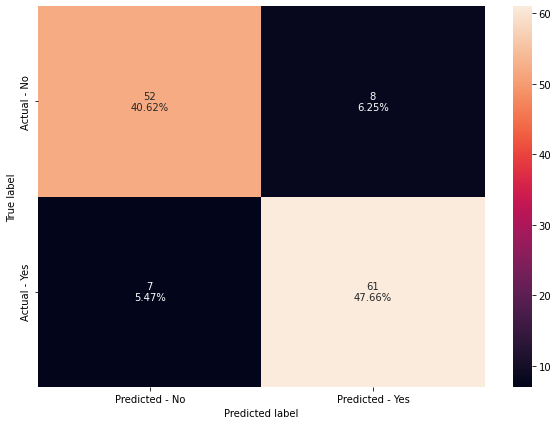

In [29]:
class tuned_bagging:
    name = "Tuned Bagging Classifier"
tuned_bagging.model = make_pipeline(
    StandardScaler(),
    BaggingClassifier(
        max_features=0.8,
        max_samples=0.7,
        random_state=1,
        n_estimators=50,
    ),
)
class_list.append(tuned_bagging)
Everything_Everywhere_All_At_Once(tuned_bagging,X_train_scaled,y_train,X_test_scaled,y_test)

In [30]:
# # Creating pipeline
# pipe = make_pipeline(StandardScaler(), RandomForestClassifier(random_state=1))

# # Parameter grid to pass in GridSearchCV

# param_grid = {
#     "randomforestclassifier__n_estimators": [100,150,250],
#     "randomforestclassifier__min_samples_leaf": np.arange(1, 6),
#     "randomforestclassifier__max_features": [np.arange(0.3, 0.6, 0.1),'sqrt','log2'],
#     "randomforestclassifier__max_samples": np.arange(0.2, 0.6, 0.1),
# }

# # Type of scoring used to compare parameter combinations
# scorer = metrics.make_scorer(metrics.accuracy_score)

# # Calling GridSearchCV
# grid_cv = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=scorer, cv=5, n_jobs = -1)

# # Fitting parameters in GridSeachCV
# grid_cv.fit(X_train_scaled, y_train)

# print(
#     "Best Parameters:{} \nScore: {}".format(grid_cv.best_params_, grid_cv.best_score_)
# )

Model creation, fitting, and assesment of the Tuned Random Forest Classifier model:
Model build and fitted :)
--------------------------------------------------
Accuracy on training set :  0.9450261780104712
Accuracy on test set :  0.8828125
Recall on training set :  0.946078431372549
Recall on test set :  0.8970588235294118
Precision on training set :  0.9507389162561576
Precision on test set :  0.8840579710144928
--------------------------------------------------


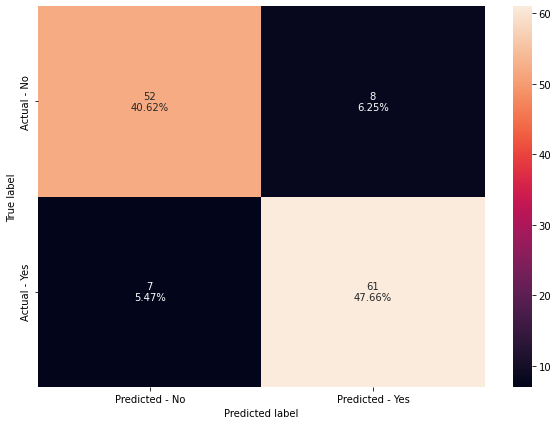

In [31]:
class tuned_randiforestclass:
    name = "Tuned Random Forest Classifier"
tuned_randiforestclass.model = make_pipeline(
    StandardScaler(),
    RandomForestClassifier(
        n_estimators=250,
        max_features='sqrt',
        random_state=1,
        max_samples=0.5,
        min_samples_leaf=2
    ),
)
class_list.append(tuned_randiforestclass)
Everything_Everywhere_All_At_Once(tuned_randiforestclass,X_train_scaled,y_train,X_test_scaled,y_test)

In [32]:
# # Creating pipeline
# pipe = make_pipeline(StandardScaler(), AdaBoostClassifier(random_state=1))

# # Parameter grid to pass in GridSearchCV
# param_grid = {
#     "adaboostclassifier__n_estimators": np.arange(10, 110, 10),
#     "adaboostclassifier__learning_rate": [0.1, 0.01, 0.2, 0.05, 1],
#     "adaboostclassifier__base_estimator": [
#         DecisionTreeClassifier(max_depth=1, random_state=1),
#         DecisionTreeClassifier(max_depth=2, random_state=1),
#         DecisionTreeClassifier(max_depth=3, random_state=1),
#     ],
# }

# # Type of scoring used to compare parameter combinations
# scorer = metrics.make_scorer(metrics.accuracy_score)

# # Calling GridSearchCV
# grid_cv = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=scorer, cv=5, n_jobs = -1)

# # Fitting parameters in GridSeachCV
# grid_cv.fit(X_train_scaled, y_train)

# print(
#     "Best Parameters:{} \nScore: {}".format(grid_cv.best_params_, grid_cv.best_score_)
# )

Model creation, fitting, and assesment of the Tuned AdaBoost Classifier model:
Model build and fitted :)
--------------------------------------------------
Accuracy on training set :  0.9214659685863874
Accuracy on test set :  0.8828125
Recall on training set :  0.9411764705882353
Recall on test set :  0.8970588235294118
Precision on training set :  0.9142857142857143
Precision on test set :  0.8840579710144928
--------------------------------------------------


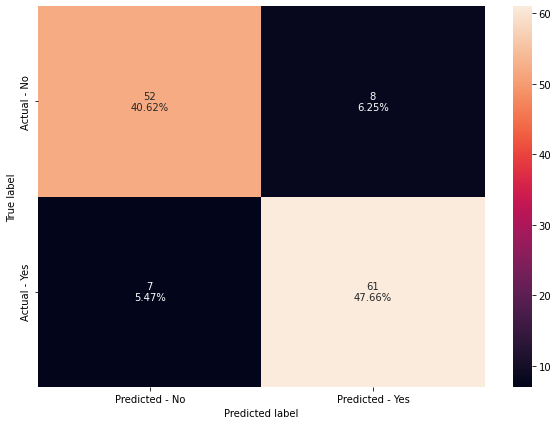

In [33]:
class tuned_adaboost:
    name = "Tuned AdaBoost Classifier"
tuned_adaboost.model = make_pipeline(
    StandardScaler(),
    AdaBoostClassifier(
        base_estimator=DecisionTreeClassifier(max_depth=1, random_state=1),
        n_estimators=30,
        learning_rate=0.05,
        random_state=1,
    ),
)
class_list.append(tuned_adaboost)
Everything_Everywhere_All_At_Once(tuned_adaboost,X_train_scaled,y_train,X_test_scaled,y_test)

In [34]:
# # Creating pipeline
# pipe = make_pipeline(StandardScaler(), GradientBoostingClassifier(random_state=1))

# # Parameter grid to pass in GridSearchCV
# param_grid = {
#     "gradientboostingclassifier__init": [AdaBoostClassifier(random_state=1),DecisionTreeClassifier(random_state=1)],
#     "gradientboostingclassifier__n_estimators": np.arange(75,150,25),
#     "gradientboostingclassifier__learning_rate": [0.1, 0.01, 0.2, 0.05, 1],
#     "gradientboostingclassifier__subsample":[0.5,0.7,1],
#     "gradientboostingclassifier__max_features":[0.5,0.7,1],
# }

# # Type of scoring used to compare parameter combinations
# scorer = metrics.make_scorer(metrics.accuracy_score)

# # Calling GridSearchCV
# grid_cv = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=scorer, cv=5, n_jobs = -1)

# # Fitting parameters in GridSeachCV
# grid_cv.fit(X_train_scaled, y_train)

# print(
#     "Best Parameters:{} \nScore: {}".format(grid_cv.best_params_, grid_cv.best_score_)
# )

Model creation, fitting, and assesment of the Tuned Gradient Boosting Classifier model:
Model build and fitted :)
--------------------------------------------------
Accuracy on training set :  0.981675392670157
Accuracy on test set :  0.875
Recall on training set :  0.9852941176470589
Recall on test set :  0.8970588235294118
Precision on training set :  0.9804878048780488
Precision on test set :  0.8714285714285714
--------------------------------------------------


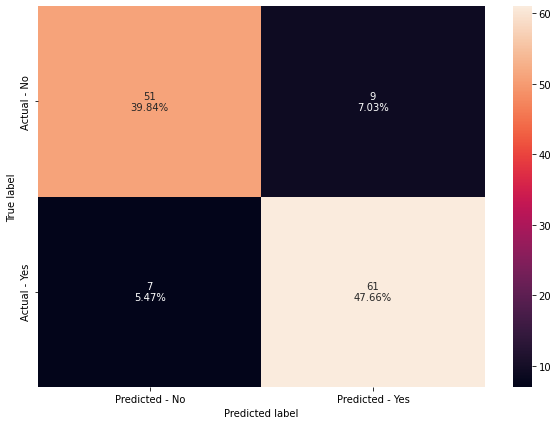

In [35]:
class tuned_gradientboost:
    name = "Tuned Gradient Boosting Classifier"
tuned_gradientboost.model = make_pipeline(
    StandardScaler(),
    GradientBoostingClassifier(
        init=AdaBoostClassifier(random_state=1),
        learning_rate=0.1,
        max_features=1,
        n_estimators=100,
        subsample=0.5,
        random_state=1,
    ),
)
class_list.append(tuned_gradientboost)
Everything_Everywhere_All_At_Once(tuned_gradientboost,X_train_scaled,y_train,X_test_scaled,y_test)

In [36]:
# #Creating pipeline
# pipe=make_pipeline(StandardScaler(), XGBClassifier(random_state=1,eval_metric='logloss'))

# #Parameter grid to pass in GridSearchCV
# param_grid={'xgbclassifier__n_estimators':np.arange(50,300,50),'xgbclassifier__scale_pos_weight':[0,1,2,5,10],
#             'xgbclassifier__learning_rate':[0.01,0.1,0.2,0.05], 'xgbclassifier__gamma':[0,1,3,5],
#             'xgbclassifier__subsample':[0.7,0.8,0.9,1]}

# # Type of scoring used to compare parameter combinations
# scorer = metrics.make_scorer(metrics.accuracy_score)

# # Calling GridSearchCV
# grid_cv = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=scorer, cv=5, n_jobs = -1)

# # Fitting parameters in GridSeachCV
# grid_cv.fit(X_train_scaled, y_train)

# print(
#     "Best Parameters:{} \nScore: {}".format(grid_cv.best_params_, grid_cv.best_score_)
# )

Model creation, fitting, and assesment of the Tuned Extreme Gradient Boosting Classifier model:
Model build and fitted :)
--------------------------------------------------
Accuracy on training set :  0.9554973821989529
Accuracy on test set :  0.8828125
Recall on training set :  0.9705882352941176
Recall on test set :  0.8970588235294118
Precision on training set :  0.9473684210526315
Precision on test set :  0.8840579710144928
--------------------------------------------------


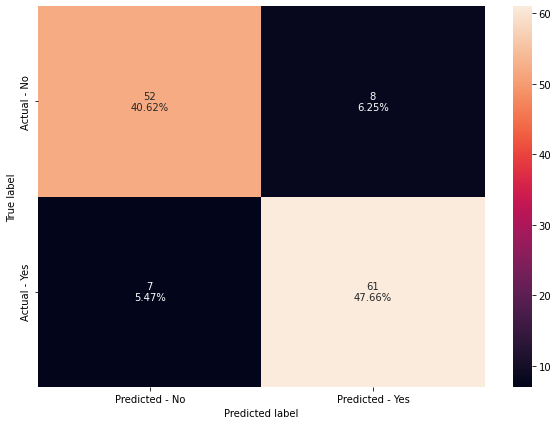

In [37]:
class tuned_xgboost:
    name = "Tuned Extreme Gradient Boosting Classifier"
tuned_xgboost.model = make_pipeline(
    StandardScaler(),
    XGBClassifier(
        random_state=1,
        n_estimators=100,
        scale_pos_weight=1,
        subsample=0.7,
        learning_rate=0.1,
        gamma=3,
        eval_metric='logloss',
    ),
)
class_list.append(tuned_xgboost)
Everything_Everywhere_All_At_Once(tuned_xgboost,X_train_scaled,y_train,X_test_scaled,y_test)

In [38]:
# Once again creating a comparison frame, this time adding the tuned models.
model_names = []
acc_train = []
acc_test = []
recall_train = []
recall_test = []
precision_train = []
precision_test = []
for model_class in class_list:
    model_names.append(model_class.name)
    acc_train.append(model_class.scores[0])
    acc_test.append(model_class.scores[1])
    recall_train.append(model_class.scores[2])
    recall_test.append(model_class.scores[3])
    precision_train.append(model_class.scores[4])
    precision_test.append(model_class.scores[5])

In [39]:
# Make the frame with these lists.
comparison_frame = pd.DataFrame(
    {
        "Model": model_names,
        "Train_Accuracy": acc_train,
        "Test_Accuracy": acc_test,
        "Train_Recall": recall_train,
        "Test_Recall": recall_test,
        "Train_Precision": precision_train,
        "Test_Precision": precision_test,
    }
)
comparison_frame.sort_values(by='Test_Accuracy')
comparison_frame

,Model,Train_Accuracy,Test_Accuracy,Train_Recall,Test_Recall,Train_Precision,Test_Precision
0,Decision Tree Classifier,1.000,0.812,1.000,0.824,1.000,0.824
1,Bagging Classifier,0.997,0.875,0.995,0.882,1.000,0.882
2,Logistic Regression Classifier,0.919,0.891,0.941,0.926,0.910,0.875
3,Random Forest Classifier,1.000,0.883,1.000,0.897,1.000,0.884
4,AdaBoost Classifier,0.976,0.812,0.971,0.897,0.985,0.782
5,Gradient Boosting Classifier,1.000,0.875,1.000,0.897,1.000,0.871
6,Extreme Gradient Boosting Classifier,1.000,0.875,1.000,0.912,1.000,0.861
7,Tuned Decision Tree Classifier,0.927,0.867,0.922,0.868,0.940,0.881
8,Tuned Bagging Classifier,1.000,0.883,1.000,0.897,1.000,0.884
9,Tuned Random Forest Classifier,0.945,0.883,0.946,0.897,0.951,0.884


In [40]:
comparison_frame.sort_values(by=['Test_Accuracy'], inplace=True, ascending=False)
comparison_frame.reset_index(inplace=True,drop=True)
#comparison_frame.drop('index')
comparison_frame

,Model,Train_Accuracy,Test_Accuracy,Train_Recall,Test_Recall,Train_Precision,Test_Precision
0,Logistic Regression Classifier,0.919,0.891,0.941,0.926,0.910,0.875
1,Random Forest Classifier,1.000,0.883,1.000,0.897,1.000,0.884
2,Tuned Bagging Classifier,1.000,0.883,1.000,0.897,1.000,0.884
3,Tuned Random Forest Classifier,0.945,0.883,0.946,0.897,0.951,0.884
4,Tuned AdaBoost Classifier,0.921,0.883,0.941,0.897,0.914,0.884
5,Tuned Extreme Gradient Boosting Classifier,0.955,0.883,0.971,0.897,0.947,0.884
6,Bagging Classifier,0.997,0.875,0.995,0.882,1.000,0.882
7,Gradient Boosting Classifier,1.000,0.875,1.000,0.897,1.000,0.871
8,Extreme Gradient Boosting Classifier,1.000,0.875,1.000,0.912,1.000,0.861
9,Tuned Gradient Boosting Classifier,0.982,0.875,0.985,0.897,0.980,0.871


In [41]:
top_name = comparison_frame['Model'][0]
second_best = comparison_frame['Model'][1]
third_best = comparison_frame['Model'][2]
print(f"Best model is the {top_name} model\n"
     f"Second best model is the {second_best} model\n"
     f"Third best model is the {third_best} model")

Best model is the Logistic Regression Classifier model
Second best model is the Random Forest Classifier model
Third best model is the Tuned Bagging Classifier model


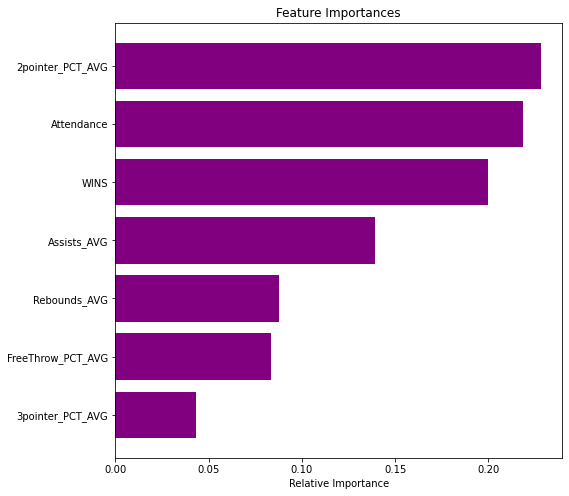

In [42]:
#example of feature importance.
feature_names = X_train.columns
importances = randiforestclass.model[1].feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(8, 8))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="purple", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

In [43]:
top_name = comparison_frame['Model'][0]
second_best = comparison_frame['Model'][1]
third_best = comparison_frame['Model'][2]
print(f"Best model is the {top_name} model\n"
     f"Second best model is the {second_best} model\n"
     f"Third best model is the {third_best} model")


Best model is the Logistic Regression Classifier model
Second best model is the Random Forest Classifier model
Third best model is the Tuned Bagging Classifier model


In [44]:
# export the model
import pickle
for model_class in class_list:
    if model_class.name == top_name:
        filename = f'../Models/Best_Games_{top_name}.sav'
        pickle.dump(model_class.model, open(filename, 'wb'))
    elif model_class.name == second_best:
        filename = f'../Models/Second_Games_{second_best}.sav'
        pickle.dump(model_class.model, open(filename, 'wb'))
    elif model_class.name == third_best:
        filename = f'../Models/Third_Games_{third_best}.sav'
        pickle.dump(model_class.model, open(filename, 'wb'))

In [46]:
#export the scaler
filename = filename = f'../Models/scaler_for_Logistic_Regression_Classifier.sav'
pickle.dump(X_scaler, open(filename, 'wb'))